In [1]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2.9000     ✔ purrr   0.3.4     
✔ tibble  3.0.1          ✔ dplyr   1.0.0     
✔ tidyr   1.1.0          ✔ stringr 1.4.0     
✔ readr   1.3.1          ✔ forcats 0.5.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



character(0)

In [2]:

library('igraph')
library('Matrix')
library('pracma')


create_transition_matrix = function (g){
    
    # WARNING: make sure your graph is connected (you might input GCC of your graph)
    
    vs = V(g)
    n = vcount(g)
    adj = as_adjacency_matrix(g)
    adj[diag(rowSums(adj) == 0)] = 1  # handle if the user is using the function for networks with isolated nodes by creating self-edges
    z = matrix(rowSums(adj, , 1))
    
    transition_matrix = adj / repmat(z, 1, n)  # normalize to get probabilities
    
    return(transition_matrix)
}

random_walk = function (g, num_steps, start_node, transition_matrix = NULL){
    if(is.null(transition_matrix))
        transition_matrix = create_transition_matrix(g)
        
    v = start_node
    for(i in 1:num_steps){
        fprintf('Step %d: %d\n', i, v)  # COMMENT THIS
        PMF = transition_matrix[v, ]
        v = sample(1:vcount(g), 1, prob = PMF)        
    }
    
    return(v)
}


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘pracma’


The following objects are masked from ‘package:Matrix’:

    expm, lu, tril, triu


The following object is masked from ‘package:purrr’:

    cross




In [3]:
#examples of how to use functions

if(FALSE){
    set.seed(0)
    g = random.graph.game(8, 0.3)
    plot(g)
    print(create_transition_matrix(g))
    set.seed(1)
    g = random.graph.game(8, 0.4, directed = T)
    plot(g)
    print(create_transition_matrix(g))
    set.seed(1)
    v_last = random_walk(g, 15, 1)
    
    
    
    }

In [4]:
evaluate_page_rank = function(g, numsteps, numiterations, teleportProbability, teleportType) {
    # Get the number of steps that need to pass before graph is in "steady state"
    steadyStateSteps = ceiling(log(vcount(g)))
    
    # Initialize the vector that stores the counts of each node after steady state
    visitedCounts = rep(0,vcount(g))
    
    # Have a vector to store the index of each node
    indexList = seq(from=1,to=vcount(g))
    
    # Get the transition matrix
    transitionMatrix = create_transition_matrix(g)
    
    # Page rank 
    pagerank = page_rank(g)
    pagerank = pagerank$vector
    sortedPagerank = order(pagerank)
    prMedians = c(sortedPagerank[floor(vcount(g)/2)], sortedPagerank[floor(vcount(g)/2)+1])

    for (i in 1:numiterations) {
        visitedNodes = random_walk(g,start=sample(indexList,1),num_steps=numsteps,transitionMatrix,
                                  teleport=teleportProbability,teleport_type=teleportType,pr=pagerank,
                                  medians=prMedians)
        for (j in 1:length(visitedNodes)) {
            if (j > steadyStateSteps) {
                visitedCounts[visitedNodes[j]] = visitedCounts[visitedNodes[j]] + 1
            }
        }
    }
    nodeProbabilities = visitedCounts / ((numsteps-steadyStateSteps) * numiterations)
    return(nodeProbabilities)
}

In [5]:
random_walk_custom = function (g, num_steps, start_node, transition_matrix = NULL, teleportation=0.0, teleport_visit_mode="equal"){
    if(is.null(transition_matrix))
        transition_matrix = create_transition_matrix(g)
        
    v = start_node
    vert_seq = array(NA, length(num_steps))
    
    switch(teleport_visit_mode, 
    "equal"={
        visit_probs=array(1/vcount(g), vcount(g))
    },
    "pg"={
        pg_ranks=page_rank(g, directed=T)$vector
        visit_probs=pg_ranks/sum(pg_ranks)   
    },
    "pg_median"={
        pg_ranks=page_rank(g, directed=T)$vector
        df = data.frame("idx"=1:vcount(g), "val"=pg_ranks)
        df=df[order(df$val),]
        visit_probs=array(0, vcount(g))
        mid=vcount(g) %/% 2
        visit_probs[df$idx[mid:mid+1]]=0.5
    },
    {
       visit_probs=array(1/vcount(g), vcount(g))
    }
    )
    
    
    
    
    for(i in 1:num_steps){
        if(runif(1)<teleportation){
            v = sample(1:vcount(g), 1, prob = visit_probs)   
        }
        else{
            PMF = transition_matrix[v, ]
            v = sample(1:vcount(g), 1, prob = PMF)   
        }     
        vert_seq[i] = v
    }
    
    return(vert_seq)
}

perform_random_walk_custom = function(g, steps, iters, teleportation=0.0, teleport_visit_mode="equal"){
    n_node_visits=array(0, vcount(g))
    n_steady_state = ceiling(log(vcount(g)))
    for(i in 1:iters){
        start_vert = sample(1:vcount(g), 1)
        vert_seq = random_walk_custom(g, steps, start_vert, teleportation=teleportation, teleport_visit_mode=teleport_visit_mode)
        for (j in 1:length(vert_seq)) {
            if (j > n_steady_state) {
                n_node_visits[vert_seq[j]] = n_node_visits[vert_seq[j]] + 1
            }
        }
    }
    return (n_node_visits / ((steps-n_steady_state) * iters))
}

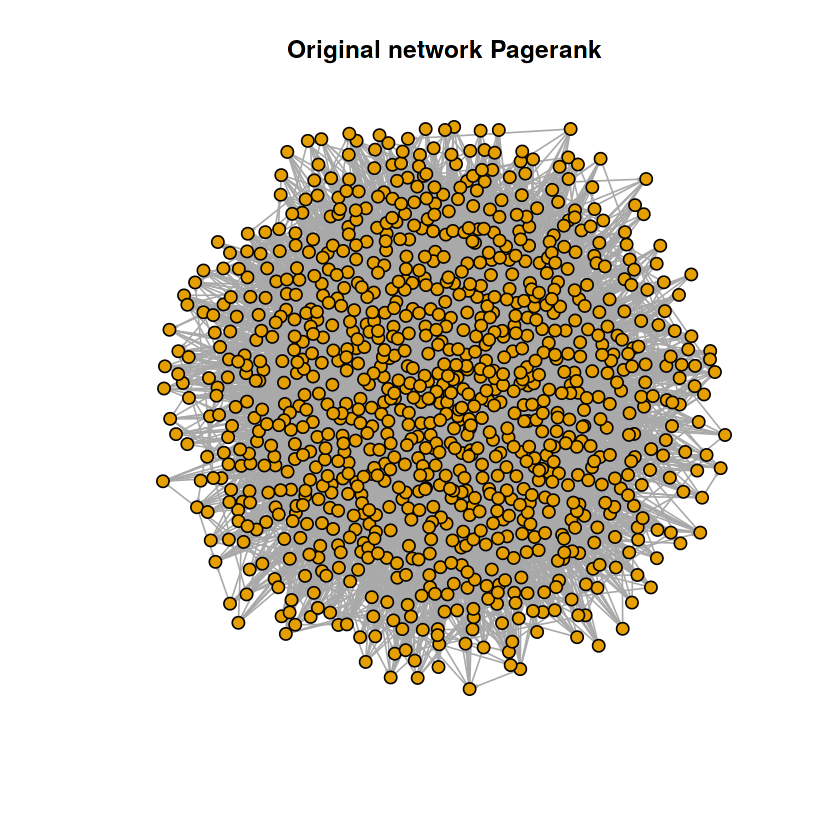

In [6]:
#part a

g1 <- sample_pa(n=1000, m=4, directed=T)
g2 <- sample_pa(n=1000, m=4, directed=T)
g2p <- permute(g2, sample(vcount(g2)))
g11 = add_edges(g1, c(t(as_edgelist(g2p))))

plot(g11, edge.arrow.size=.1, vertex.size=4, vertex.label=NA, main="Original network Pagerank")



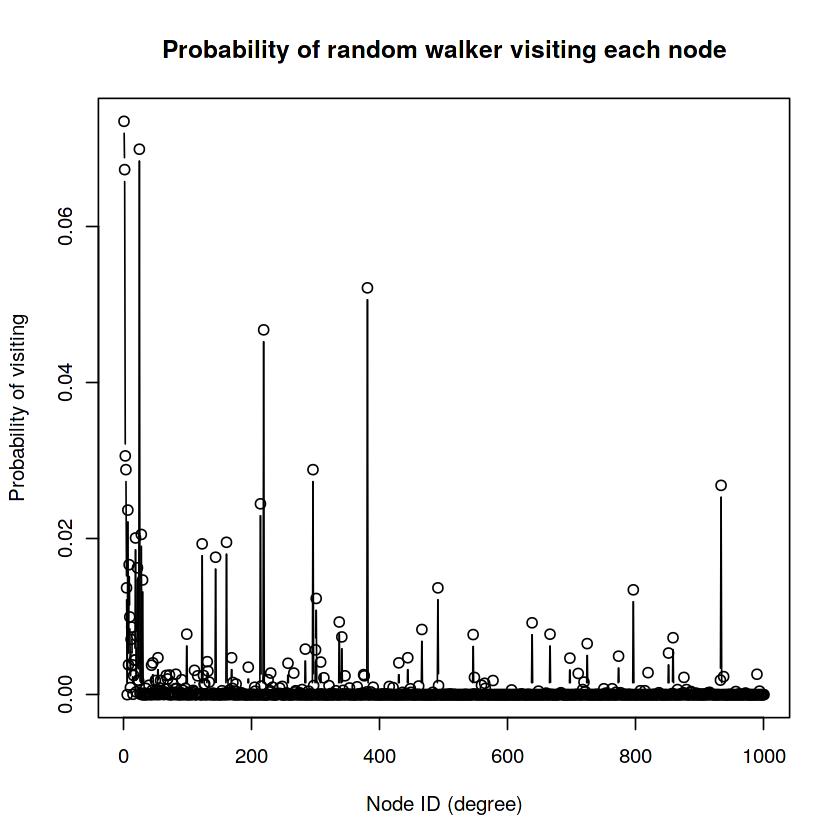

In [7]:
set.seed(1)
iters=20
steps=1000
node_visits_probs=perform_random_walk_custom(g11, steps, iters)
plot(node_visits_probs, type="b", xlab='Node ID (degree)', ylab='Probability of visiting', main='Probability of random walker visiting each node')


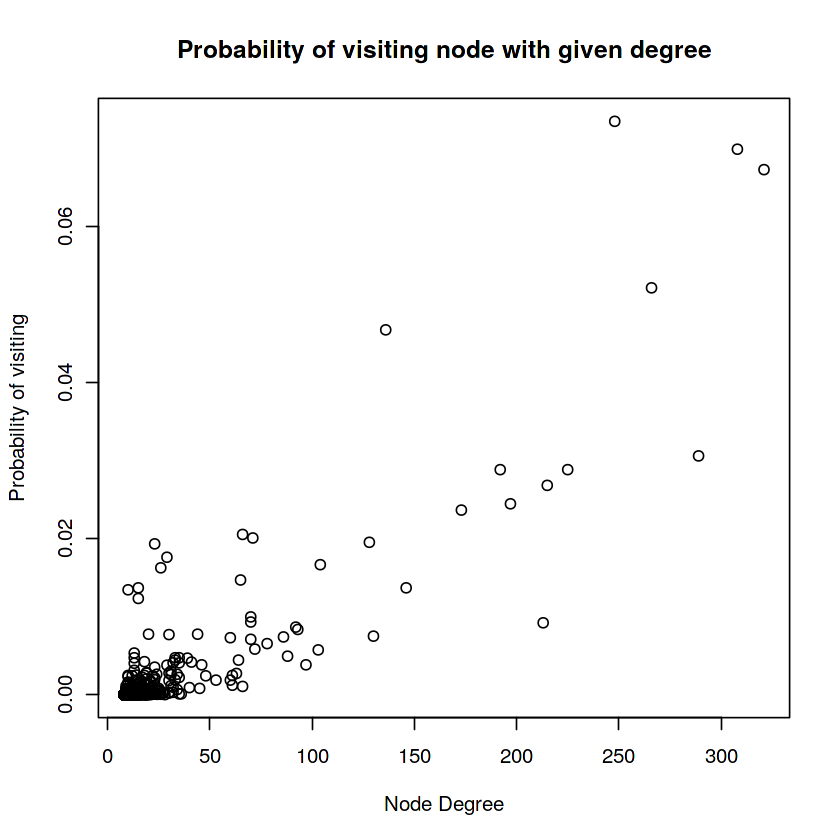

In [8]:
plot(degree(g11), node_visits_probs, xlab='Node Degree', ylab='Probability of visiting', main='Probability of visiting node with given degree')


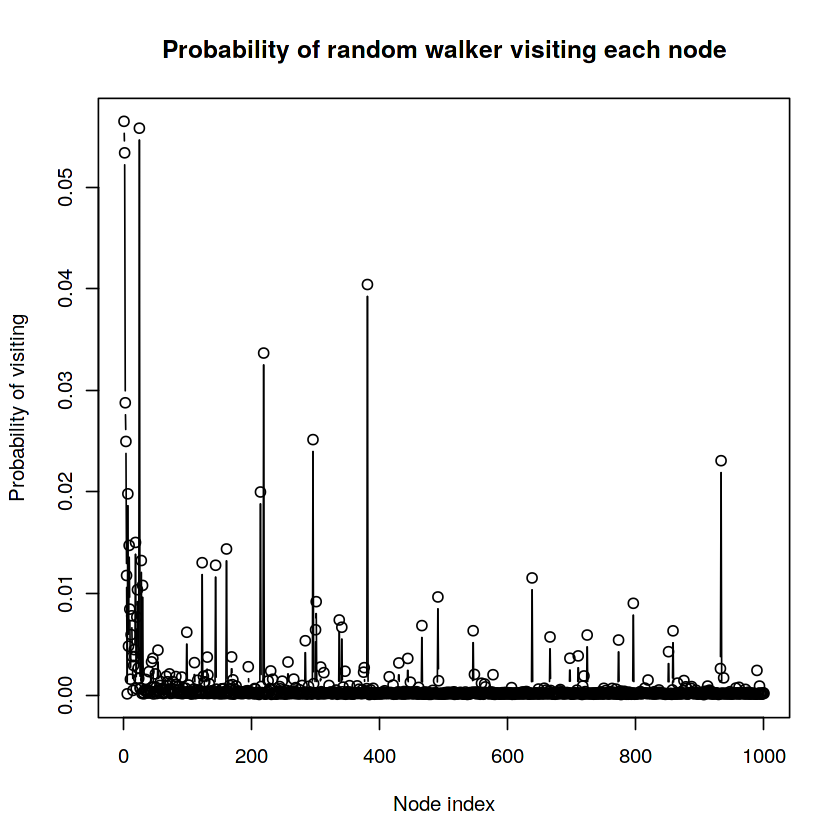

In [9]:
#part b

iters=100
steps=1000
alpha=0.15
node_visits_probs_equal=perform_random_walk_custom(g11, steps, iters, teleportation=alpha, teleport_visit_mode="equal")
plot(node_visits_probs_equal, type="b", xlab='Node index', ylab='Probability of visiting', main='Probability of random walker visiting each node')

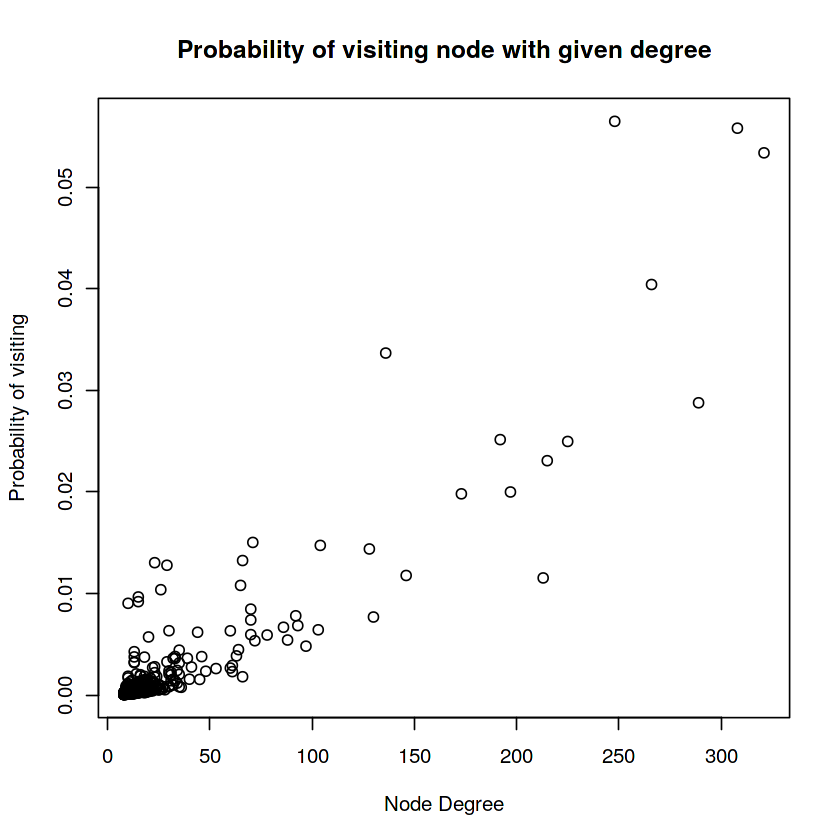

In [10]:
plot(degree(g11), node_visits_probs_equal, xlab='Node Degree', ylab='Probability of visiting', main='Probability of visiting node with given degree')


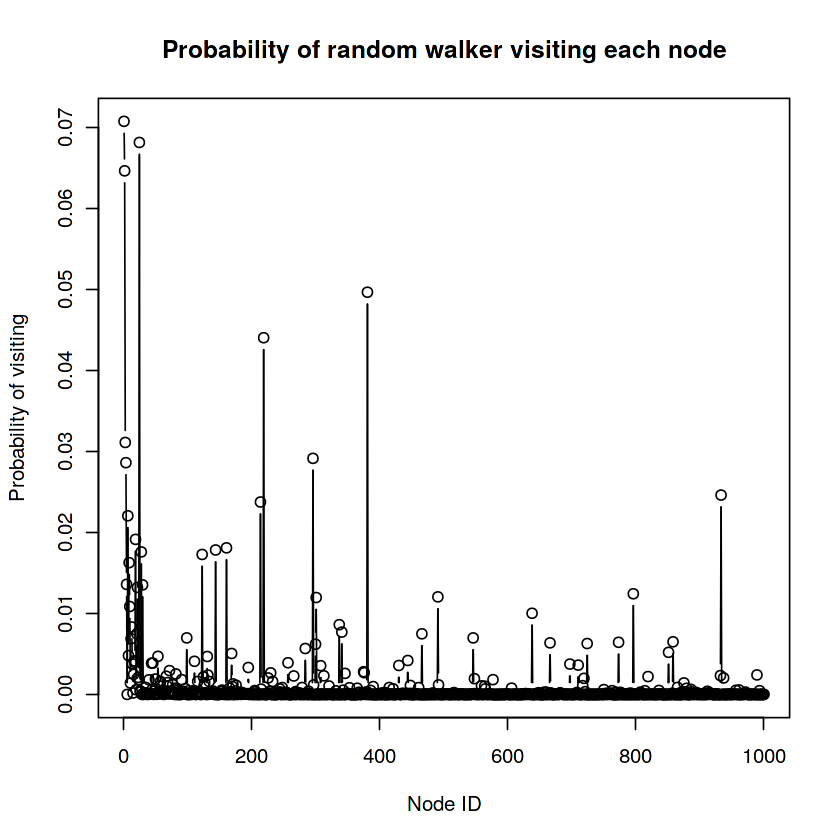

In [11]:
#question 4 part a

node_visits_probs_pg=perform_random_walk_custom(g11, steps, iters, teleportation=alpha, teleport_visit_mode="pg")

plot(node_visits_probs_pg, type="b", xlab='Node ID', ylab='Probability of visiting', main='Probability of random walker visiting each node')


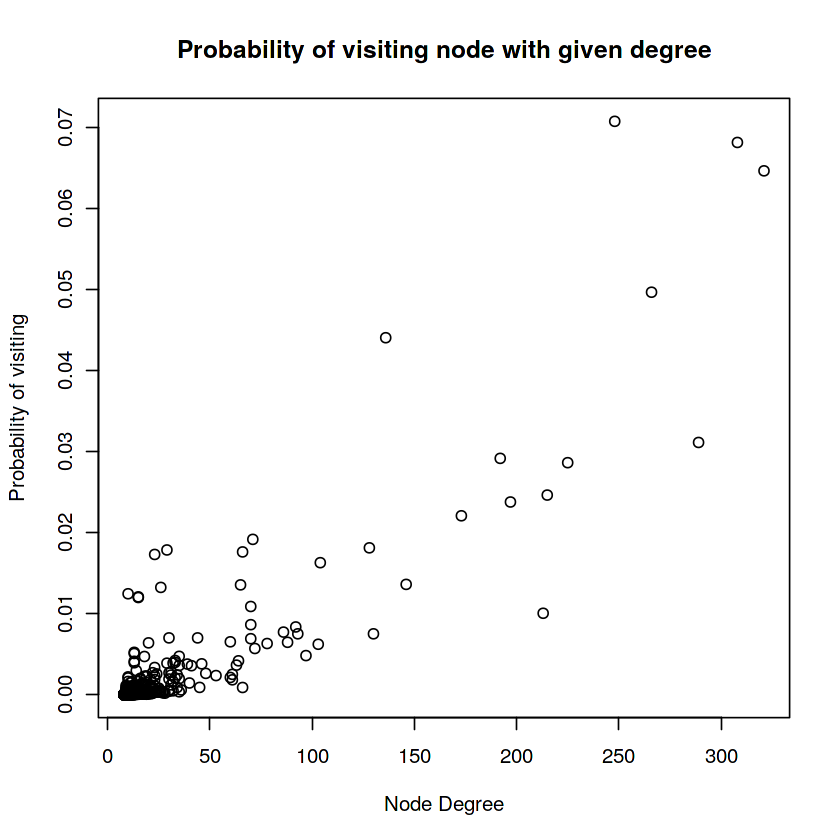

In [12]:
plot(degree(g11), node_visits_probs_pg, xlab='Node Degree', ylab='Probability of visiting', main='Probability of visiting node with given degree')


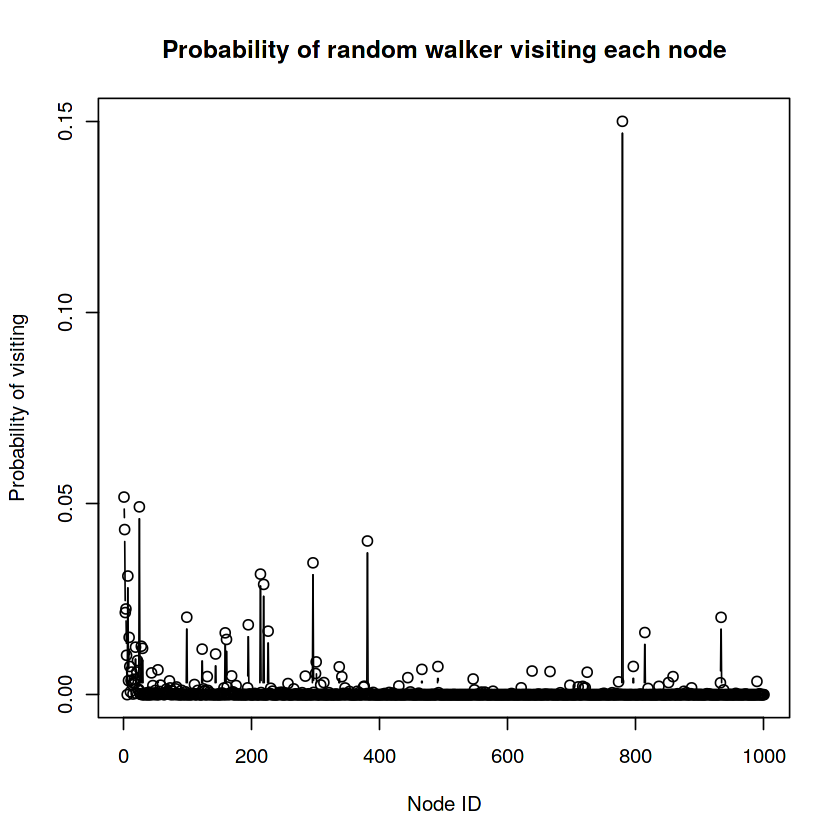

In [13]:
# question 4b

n_node_visits_pg_median=perform_random_walk_custom(g11, steps, iters, teleportation=alpha, teleport_visit_mode="pg_median")
plot(n_node_visits_pg_median, type="b", xlab='Node ID', ylab='Probability of visiting', main='Probability of random walker visiting each node')


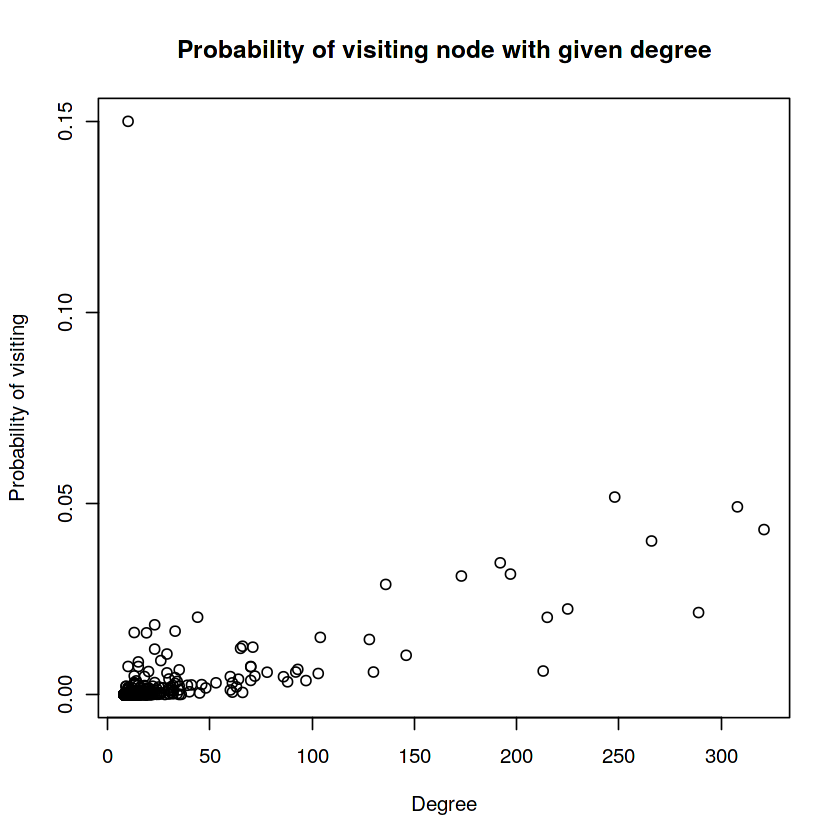

In [14]:
plot(degree(g11), n_node_visits_pg_median, xlab='Degree', ylab='Probability of visiting', main='Probability of visiting node with given degree')


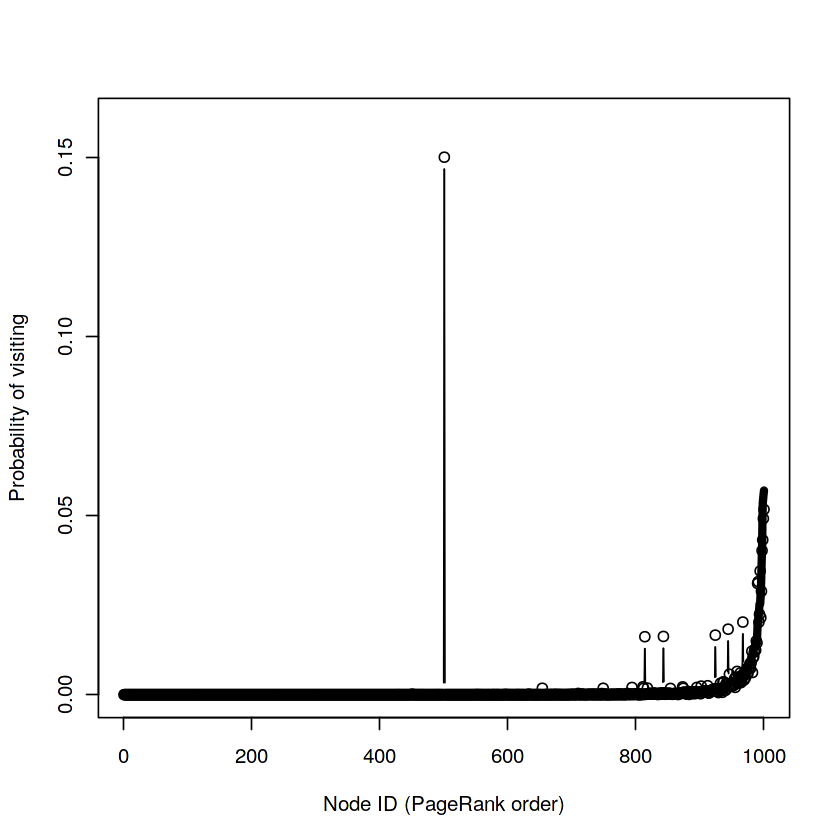

In [15]:
pageranks = page_rank(g11)$vector
plot(sort(pageranks), type='l',lwd=5, ylim=c(0,0.16), xlab='Node ID (PageRank order)', ylab='Probability of visiting')
lines(n_node_visits_pg_median[order(pageranks)], type='b')

In [16]:
#comment 